<a href="https://colab.research.google.com/github/yeesem/Time-Series-Data-Analysis/blob/main/ML_Airline_With_Differencing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget -nc https://lazyprogrammer.me/course_files/airline_passengers.csv

--2023-11-12 17:03:39--  https://lazyprogrammer.me/course_files/airline_passengers.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2036 (2.0K) [text/csv]
Saving to: ‘airline_passengers.csv’

airline_passengers. 100%[===================>]   1.99K  --.-KB/s    in 0s      

2023-11-12 17:03:39 (27.6 MB/s) - ‘airline_passengers.csv’ saved [2036/2036]



In [14]:
!pip install -U scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 64.1 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
!head airline_passengers.csv

"Month","Passengers"
"1949-01",112
"1949-02",118
"1949-03",132
"1949-04",129
"1949-05",121
"1949-06",135
"1949-07",148
"1949-08",148
"1949-09",136


In [7]:
df = pd.read_csv('airline_passengers.csv',index_col = 'Month',parse_dates = True)

In [8]:
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [10]:
df['LogPassengers'] = np.log(df['Passengers'])

In [9]:
df['LogPassengersDiff'] = np.log(df['Passengers']).diff()

In [11]:
NTest = 12
train = df.iloc[:-NTest]
test = df.iloc[-NTest:]

In [12]:
#Make supervised dataset
series = df['LogPassengersDiff'].to_numpy()[1:]

T = 10
X = []
Y = []

for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

In [13]:
XTrain,YTrain = X[:-NTest],Y[:-NTest]
XTest,YTest = X[-NTest:],Y[-NTest:]

In [17]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(XTrain,YTrain)
lr.score(XTrain,YTrain)

0.6837135048453121

In [18]:
lr.score(XTest,YTest)

0.6492870172668167

In [20]:
train_idx = df.index <= train.index[-1]
test_idx = ~train_idx

#First T+1 values are not predictable
train_idx[:T+1] = False

In [21]:
#Needed to compute un-differenced predictions
df['ShiftLogPassengers'] = df['LogPassengers'].shift(1)
prev = df['ShiftLogPassengers']

In [22]:
df.head()

,Passengers,LogPassengersDiff,LogPassengers,ShiftLogPassengers
Month,,,,
1949-01-01,112,NaN,4.718499,NaN
1949-02-01,118,0.052186,4.770685,4.718499
1949-03-01,132,0.112117,4.882802,4.770685
1949-04-01,129,-0.022990,4.859812,4.882802
1949-05-01,121,-0.064022,4.795791,4.859812


In [23]:
last_train = train.iloc[-1]['LogPassengers']

In [30]:
#1-step forecast
df.loc[train_idx,'LR_1step_train'] = prev[train_idx] + lr.predict(XTrain)
df.loc[test_idx,'LR_1step_test'] = prev[test_idx] + lr.predict(XTest)

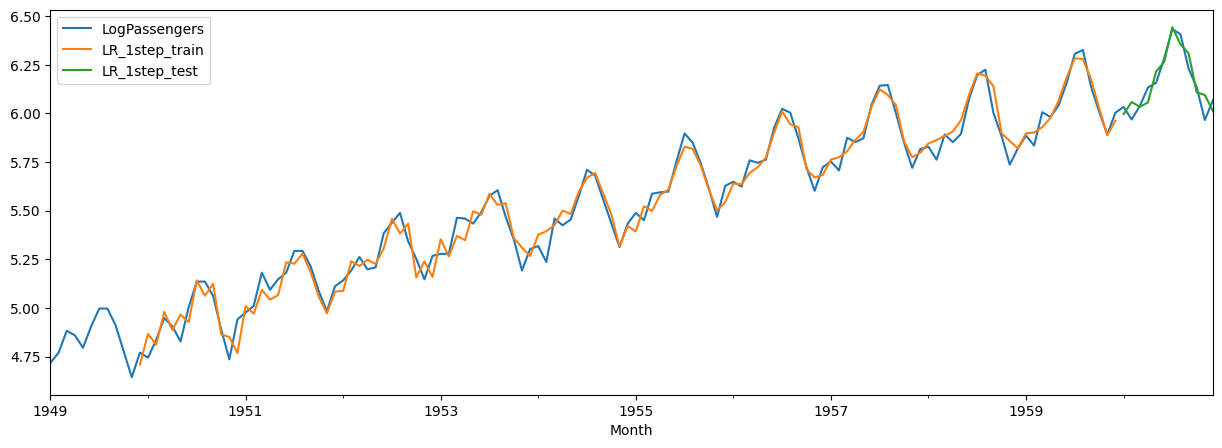

In [34]:
col = [
    "LogPassengers",
    "LR_1step_train",
    "LR_1step_test"
]
df[col].plot(figsize = (15,5));

In [40]:
#multi step forecast
multistep_predictions = []

#first test input
last_x = XTest[0]

while len(multistep_predictions) < NTest:
  p = lr.predict(last_x.reshape(1,-1))[0]

  #Update the predictions list
  multistep_predictions.append(p)

  last_x = np.roll(last_x,-1)
  last_x[-1] = p

In [41]:
#Save multi_step forecast to dataframe
df.loc[test_idx,'LR_multistep'] = last_train + np.cumsum(multistep_predictions)

<Axes: xlabel='Month'>

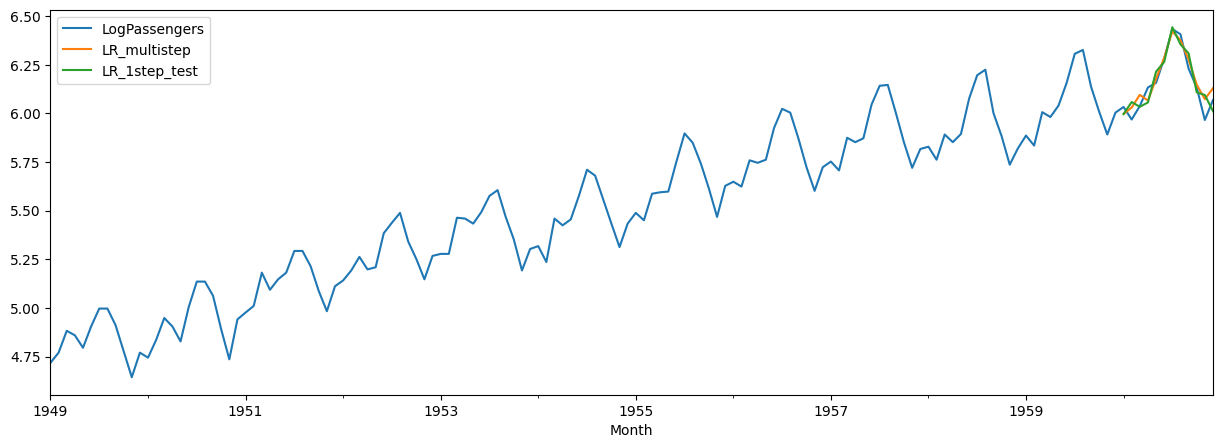

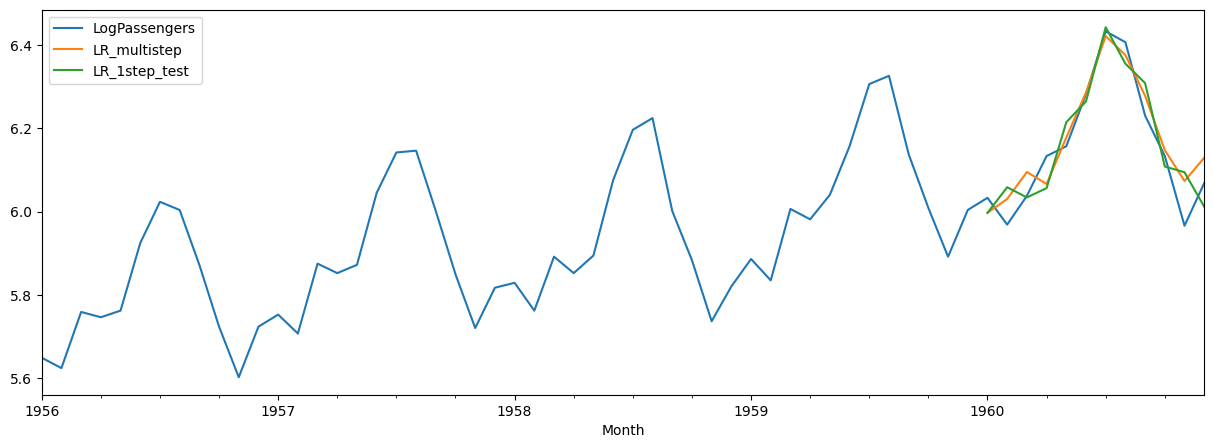

In [46]:
#Plot 1-step and multi-step forecast
col = [
    "LogPassengers",
    "LR_multistep",
    "LR_1step_test"
]
df[col].plot(figsize = (15,5))
df.iloc[-60:][col].plot(figsize = (15,5))